In [20]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import pickle

print('z')

z


In [21]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes

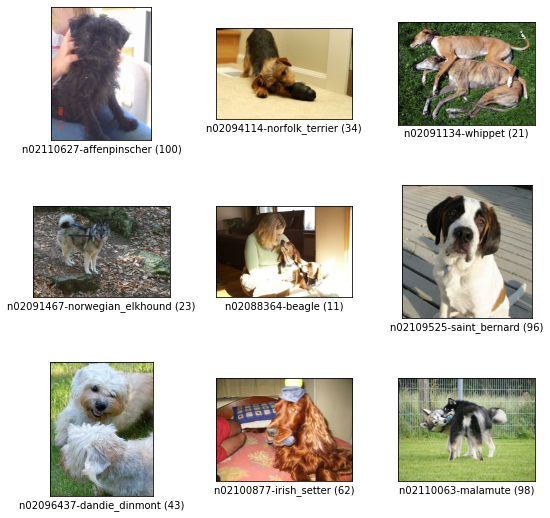

In [23]:
fig = tfds.show_examples(ds_train, ds_info)

## no_aug & with_aug(baseline)

In [24]:
def normalize_and_resize_img(image, label, mean=[125.3, 123.0, 113.9], std=[63.0, 62.1, 66.7]):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    R = tf.divide(tf.subtract(image[..., 0], mean[0]), std[0])
    G = tf.divide(tf.subtract(image[..., 1], mean[1]), std[1])
    B = tf.divide(tf.subtract(image[..., 2], mean[2]), std[2])
    
    return tf.cast(tf.stack([R,G,B], axis=-1), tf.float32), label

In [25]:
def normalize_and_resize_img_origin(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [26]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

In [27]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [28]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

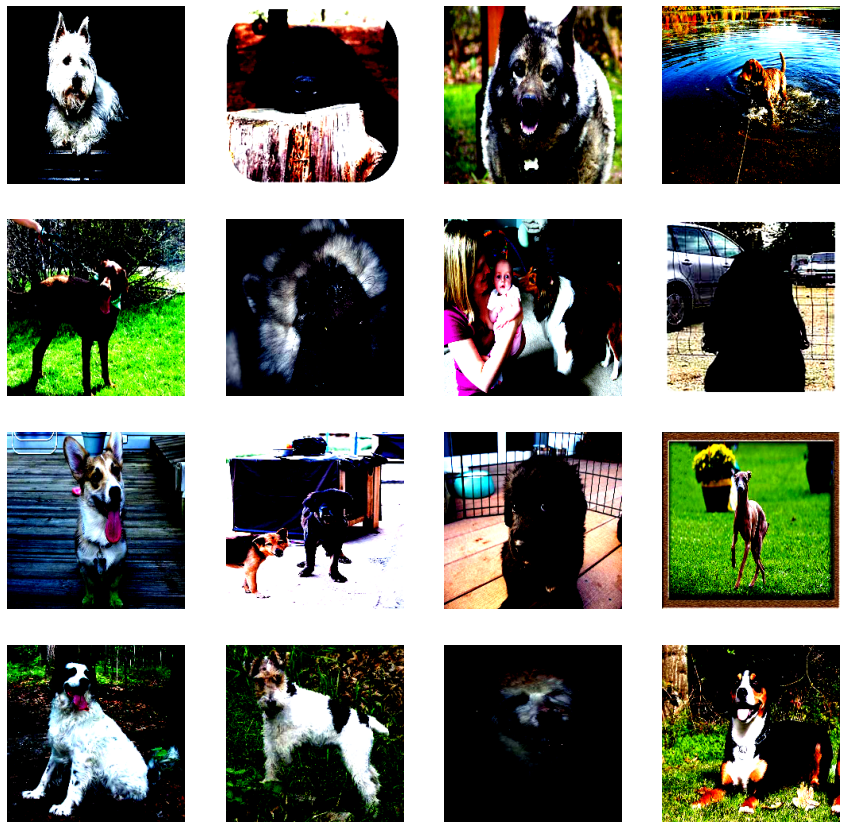

In [29]:
row = 6 
col = 4
row = min(row,16//col)

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(image[j,])

### resnet_50

In [30]:
# 일반 resnet50

num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [31]:
# augmentation 적용 할 모델 (bsseline)

resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [32]:
# #EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
# EPOCH = 20

# tf.random.set_seed(2020)
# resnet50.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
# )

# history_resnet50_no_aug = resnet50.fit(
#     ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=1,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

# resnet50.save_weights('resnet50_noaug')
# with open('./resnet50_hist', 'wb') as file_pi:
#     pickle.dump(history_resnet50_no_aug.history, file_pi)

In [33]:
# with open('./resnet50_hist', 'wb') as file_pi:
#     pickle.dump(history_resnet50_no_aug.history, file_pi)

In [34]:
history_resnet50_no_aug = pickle.load(open('./resnet50_hist', "rb"))

In [35]:
# EPOCH = 20

# resnet50_aug.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=tf.keras.optimizers.SGD(lr=0.01),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
# )

# history_resnet50_aug = resnet50_aug.fit(
#     ds_train_aug, # augmentation 적용한 데이터셋 사용
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=EPOCH,
#     validation_data=ds_test,
#     verbose=1,
#     use_multiprocessing=True,
# )

# resnet50_aug.save_weights('resnet50_aug')
# with open('./resnet50_aug_hist', 'wb') as file_pi:
#     pickle.dump(history_resnet50_aug.history, file_pi)

In [36]:
history_resnet50_aug = pickle.load(open('./resnet50_aug_hist', "rb"))

### resnet50_noaug

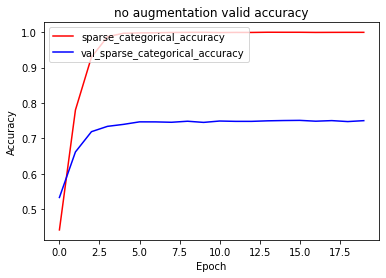

In [37]:
plt.plot(history_resnet50_no_aug['sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_no_aug['val_sparse_categorical_accuracy'], 'b')
plt.title('no augmentation valid accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], loc='upper left')
plt.show()

### renet50_with_aug(baseline)

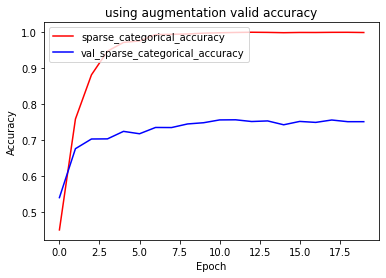

In [38]:
plt.plot(history_resnet50_aug['sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_sparse_categorical_accuracy'], 'b')
plt.title('using augmentation valid accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], loc='upper left')
plt.show()

### resnet50_noaug VS renet50_with_aug(baseline)

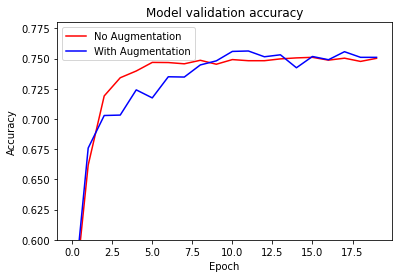

In [39]:
plt.plot(history_resnet50_no_aug['val_sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_sparse_categorical_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0.6,0.78)
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

## CutMix (with proba)

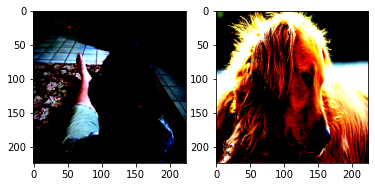

In [40]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [41]:
def get_clip_box(image_a, image_b, proba = 1.0):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)
    
    P = tf.cast( tf.random.uniform([],0,1)<=proba, tf.int32)
    
    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32) * P
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb
xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(get_clip_box(image_a, image_b))


(<tf.Tensor: shape=(), dtype=int32, numpy=48>, <tf.Tensor: shape=(), dtype=int32, numpy=76>, <tf.Tensor: shape=(), dtype=int32, numpy=224>, <tf.Tensor: shape=(), dtype=int32, numpy=224>)


In [42]:
# mix two images
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    return mixed_img

In [43]:
# mix two labels
def mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = a*label_a + (1-a)*label_b
    return mixed_label

mixed_label = mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb)
print(mixed_label)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.7714445  0.         0.         0.22855549
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0. 

In [44]:
def cutmix(image, label, prob = 0.666, batch_size=16, img_size=224, num_classes=120, proba = 1.0):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        
        xa, ya, xb, yb = get_clip_box(image_a, image_b, proba)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(image_a, image_b, label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## MixUp

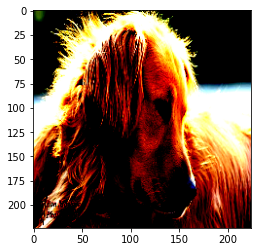

In [45]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, _ = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
#print(mixed_label)


In [46]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [47]:
def onehot(image, label):
    num_classes = 120
    onehot_label = tf.one_hot(label, num_classes)
    return image, onehot_label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    ds = ds.batch(batch_size)
    
    if not is_test and  with_aug:
        ds = ds.map(
            augment
        )
    
    if not is_test and  with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and  with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    elif not with_cutmix and not with_mixup and is_test:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## train

In [48]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [49]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, with_mixup=False)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=False, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

EPOCH = 20

In [50]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [51]:
EPOCH = 20

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_cutmix.save_weights('resnet50_cutmix')
with open('./resnet50_cutmix_hist', 'wb') as file_pi:
    pickle.dump(history_resnet50_cutmix.history, file_pi)

Train for 750 steps, validate for 536 steps
Epoch 1/20
750/750 [==============================] - 149s 199ms/step - loss: 4.6748 - categorical_accuracy: 0.0417 - val_loss: 3.2456 - val_categorical_accuracy: 0.3068
Epoch 2/20
750/750 [==============================] - 142s 189ms/step - loss: 4.2982 - categorical_accuracy: 0.0898 - val_loss: 2.9128 - val_categorical_accuracy: 0.4397
Epoch 3/20
750/750 [==============================] - 142s 190ms/step - loss: 4.0798 - categorical_accuracy: 0.1288 - val_loss: 2.6770 - val_categorical_accuracy: 0.5024
Epoch 4/20
750/750 [==============================] - 142s 190ms/step - loss: 3.9207 - categorical_accuracy: 0.1503 - val_loss: 2.4137 - val_categorical_accuracy: 0.5539
Epoch 5/20
750/750 [==============================] - 142s 189ms/step - loss: 3.7929 - categorical_accuracy: 0.1735 - val_loss: 1.9350 - val_categorical_accuracy: 0.5827
Epoch 6/20
750/750 [==============================] - 142s 189ms/step - loss: 3.6853 - categorical_accurac

In [52]:
resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

resnet50_mixup.save_weights('resnet50_mixup')
with open('./resnet50_mixup_hist', 'wb') as file_pi:
    pickle.dump(history_resnet50_mixup.history, file_pi)

Train for 750 steps, validate for 536 steps
Epoch 1/20
750/750 [==============================] - 125s 167ms/step - loss: 3.7246 - categorical_accuracy: 0.2383 - val_loss: 2.0740 - val_categorical_accuracy: 0.4525
Epoch 2/20
750/750 [==============================] - 119s 159ms/step - loss: 2.9166 - categorical_accuracy: 0.4531 - val_loss: 1.4230 - val_categorical_accuracy: 0.6107
Epoch 3/20
750/750 [==============================] - 119s 159ms/step - loss: 2.6612 - categorical_accuracy: 0.5451 - val_loss: 1.2699 - val_categorical_accuracy: 0.6468
Epoch 4/20
750/750 [==============================] - 119s 159ms/step - loss: 2.5208 - categorical_accuracy: 0.6034 - val_loss: 1.2341 - val_categorical_accuracy: 0.6526
Epoch 5/20
750/750 [==============================] - 119s 159ms/step - loss: 2.3924 - categorical_accuracy: 0.6478 - val_loss: 1.1594 - val_categorical_accuracy: 0.6765
Epoch 6/20
750/750 [==============================] - 119s 159ms/step - loss: 2.3014 - categorical_accurac

### cutmix

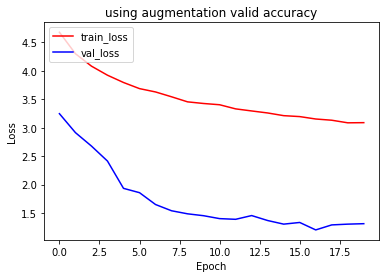

In [53]:
plt.plot(history_resnet50_cutmix.history['loss'], 'r')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.title('using augmentation valid accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

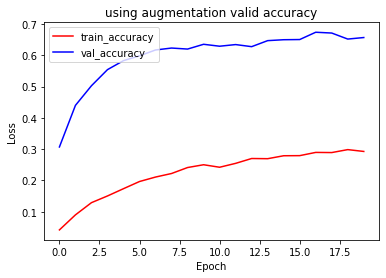

In [57]:
plt.plot(history_resnet50_cutmix.history['categorical_accuracy'], 'r')
plt.plot(history_resnet50_cutmix.history['val_categorical_accuracy'], 'b')
plt.title('using augmentation valid accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

### MixUp

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np

import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import pickle

print('z')

z


In [5]:
cutmix_hist = pickle.load(open('./aug_history_and_weights/resnet50_cutmix_hist', "rb"))
mixup_hist = pickle.load(open('./aug_history_and_weights//resnet50_mixup_hist', "rb"))

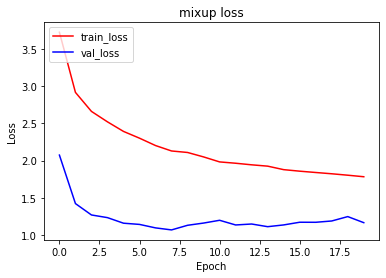

In [6]:
plt.plot(mixup_hist['loss'], 'r')
plt.plot(mixup_hist['val_loss'], 'b')
plt.title('mixup loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

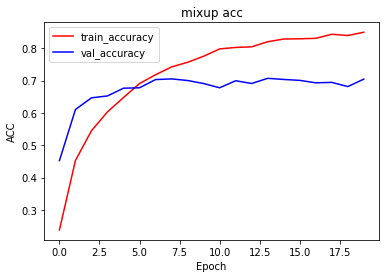

In [7]:
plt.plot(mixup_hist['categorical_accuracy'], 'r')
plt.plot(mixup_hist['val_categorical_accuracy'], 'b')
plt.title('mixup acc')
plt.ylabel('ACC')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

### no_aug VS with_aug(baseline) VS cutmix VS mixup

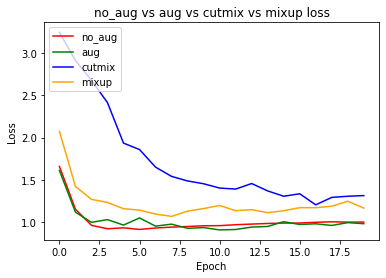

In [61]:
# sparse_categorical_accuracy
# val_sparse_categorical_accuracy
# categorical_accuracy
# val_categorical_accuracy

plt.plot(history_resnet50_no_aug['val_loss'], 'r')
plt.plot(history_resnet50_aug['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'orange')
plt.title('no_aug vs aug vs cutmix vs mixup loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'mixup'], loc='upper left')
plt.show()

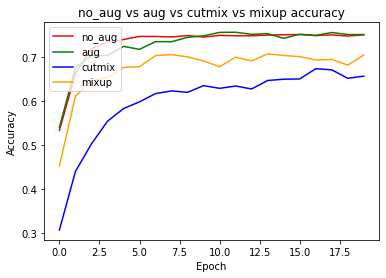

In [62]:
plt.plot(history_resnet50_no_aug['val_sparse_categorical_accuracy'], 'r')
plt.plot(history_resnet50_aug['val_sparse_categorical_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_categorical_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_categorical_accuracy'], 'orange')
plt.title('no_aug vs aug vs cutmix vs mixup accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'mixup'], loc='upper left')
plt.show()

### mixup

In [ ]:
plt.plot(history_resnet50_mixup.history['loss'], 'r')
plt.plot(history_resnet50_mixup.history['val_loss'], 'b')
plt.title('MixUp loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_mixup.history['accuracy'], 'r')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'b')
plt.title('MixUp accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

### ALL VS

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'g')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'b')
plt.plot(history_resnet50_mixup.history['val_loss'], 'orange')
plt.title('no_aug vs aug vs Cutmix vs Mixup Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'Mixup'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'g')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'b')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'orange')
plt.title('no_aug vs aug vs Cutmix vs Mixup Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['no_aug', 'aug', 'cutmix', 'Mixup'], loc='upper left')
plt.show()